In [1]:
# !pip install paddlepaddle-gpu pyclipper attrdict -qqq
# !pip install wandb -qqq
!jupyter trust /usr4/dl523/dong760/CS549_Herbarium_Project/ml-herbarium/PaddleOCR/notebook/PP_OCR_Inference.ipynb

Signing notebook: /usr4/dl523/dong760/CS549_Herbarium_Project/ml-herbarium/PaddleOCR/notebook/PP_OCR_Inference.ipynb


In [2]:
import requests
import shutil
import math
import json
from tqdm import tqdm
import glob
import random
from PIL import Image
import imghdr
from sklearn.model_selection import train_test_split
# Multiprocessing stuff
import multiprocessing as mp
NUM_CORES = min(mp.cpu_count(), 50)

# Some CV/DL module
import numpy as np
print(np.__version__)
import matplotlib.pyplot as plt
import cv2

# OCR Packages
# The paddleocr whl package will automatically download the ppocr lightweight model(PP-OCRv3) as the default model
from paddleocr import PaddleOCR, draw_ocr
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# When using matplotlib.pyplot to draw in the notebook, you need to add this command to display
%matplotlib inline

1.22.4


In [17]:
PROJECT_DIR = "/usr4/dl523/dong760/CS549_Herbarium_Project/ml-herbarium/PaddleOCR"

import time
timestr = time.strftime("%Y%m%d-%H%M%S")
DATASET_CSV = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/data.csv"
DATASET_PATH = img_dir = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/scraped-data/20220616-061434/" # 20220616-061434/ or 20220425-160006/ or drago_testdata/"
craft_res_dir = DATASET_PATH.replace('/scraped-data/', '/CRAFT-results/')
seg_img_dir = DATASET_PATH.replace('/scraped-data/', '/seg-results/')


# Loading all scrapped images

In [20]:
img_dict = {}	# Dict<int: imgId, nparr: img>

def addImg(fIdx):
    img_dict[fIdx]=cv2.imread(os.path.join(DATASET_PATH, fIdx+".jpg"))
    # 	# By default, cv2.imread() use BGR, if you want to read in grayscale use, cv2.imread('image_1.png', 1)
    # 	temp_img = cv2.imread(os.path.join(DATASET_PATH, fIdx+".jpg"))
    # 	# convert image form BGR to RGB color for matplotlib
    # 	img_dict[fIdx] = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
    return img_dict

def getOrigImgs(multi_proc=True):
    print("Getting original images...")
    print("Starting multiprocessing...")
    file_list = sorted(os.listdir(DATASET_PATH))
    imgIds_list = [img[:-4] for img in file_list if ".jpg" in img]
    if multi_proc:
        pool = mp.Pool(NUM_CORES)
        for item in tqdm(pool.imap(addImg, imgIds_list), total=len(imgIds_list)):
            img_dict.update(item)
        pool.close()
        pool.join()
    else:
        for fIdx in tqdm(imgIds_list):
            img_dict[fIdx]=cv2.imread(os.path.join(DATASET_PATH, fIdx+".jpg"))
    print("\nOriginal images obtained.\n")
getOrigImgs()
img_list = list(img_dict.items())	# a list of Tuple<int: imgId, nparr: img>

Getting original images...
Starting multiprocessing...


100%|██████████| 30/30 [00:02<00:00, 10.92it/s]


Original images obtained.



(2250, 1500, 3)

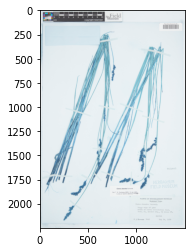

In [21]:
img = img_list[0][1]
plt.imshow(img);
img.shape

In [22]:
img_dict.keys()

dict_keys(['1228540653', '1456077691', '1675922214', '1699810828', '1701985163', '1702403767', '1805438386', '1928727829', '1930079276', '1991447360', '1998924583', '1998999444', '1999141230', '1999191965', '1999346883', '2236069168', '2265361450', '2513962787', '2514610251', '2515453969', '2516377361', '2516548361', '2517498948', '2900391670', '3016518613', '3416707636', '436989369', '437989544', '438312026', '574701445'])

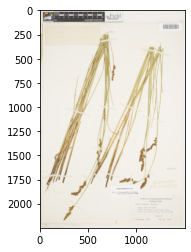

In [24]:
def display_img_with_imgID(imgID):
    img = img_dict[imgID]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img);
display_img_with_imgID('1228540653') # 1228540653 

# Looking at PaddleOCR
```python
# Download package
!pip install paddlepaddle paddleocr
```

## Using default PaddleOCR model to perform detection only

In [46]:
# 1. Import PaddleOCR class from paddleocr
from paddleocr import PaddleOCR

# 2. Declare the PaddleOCR class
ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu = False)
# img_path ='./12.jpg'
img = img_list[0][1]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 3. Perform prediction
result = ocr.ocr(img, rec=False) # support ndarray, img_path and list or ndarray
# print(f"The predicted text box of {img} are follows.")
# print(result)

[2022/11/07 16:57:44] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/usr4/dl523/dong760/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/usr4/dl523/dong760/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thr

In [48]:
result = np.squeeze(np.array(result))
result.shape

(1, 19, 4, 2)

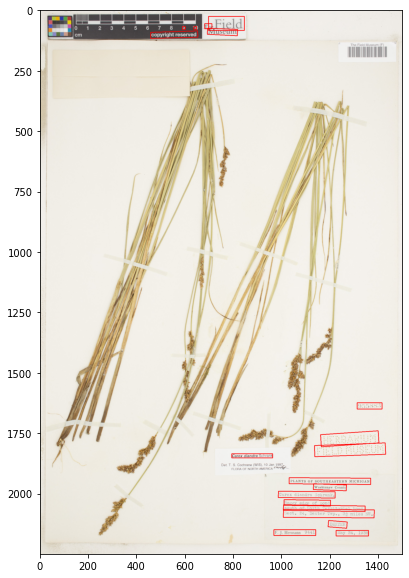

In [39]:
def draw_bbox_on_img(image, seg_result):
    boxes = [line[0] for line in seg_result]
    for box in seg_result:
        box = np.reshape(np.array(box), [-1, 1, 2]).astype(np.int64)
        image = cv2.polylines(np.array(image), [box], True, (255, 0, 0), 2)
    # 画出读取的图片
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
# result = np.squeeze(np.array(result))
draw_bbox_on_img(img, result)

## Let's use PaddleOCR on both detection and recognization

In [40]:
# Paddleocr supports Chinese, English, French, German, Korean and Japanese.
# You can set the parameter `lang` as `ch`, `en`, `french`, `german`, `korean`, `japan`
# to switch the language model in order.
ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu=False) # need to run only once to download and load model into memory
# img_path = 'PaddleOCR/doc/imgs_en/img_12.jpg'
result = ocr.ocr(img, cls=True)
# Print each result as a line
for idx in range(len(result)):
    res = result[idx]
    for line in res:
        print(line)

# draw result
from PIL import Image
result = result[0]
# image = Image.open(img_path).convert('RGB')
boxes = [line[0] for line in result]
txts = [line[1][0] for line in result]
scores = [line[1][1] for line in result]
im_show = draw_ocr(img,   # image(Image|array): RGB image
                   boxes, # boxes(list): boxes with shape(N, 4, 2)
                   txts,  # txts(list): the texts
                   scores, # confidence
                   drop_score=0.1, # drop_score(float): only scores greater than drop_threshold will be visualized
                   font_path='./doc/fonts/simfang.ttf') # font_path: the path of font which is used to draw text
im_show = Image.fromarray(im_show)
im_show.save('./output/result.jpg')

[2022/11/07 16:56:50] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/usr4/dl523/dong760/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/usr4/dl523/dong760/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thr

**Output will be a list, each item contains bounding box, text and recognition confidence**

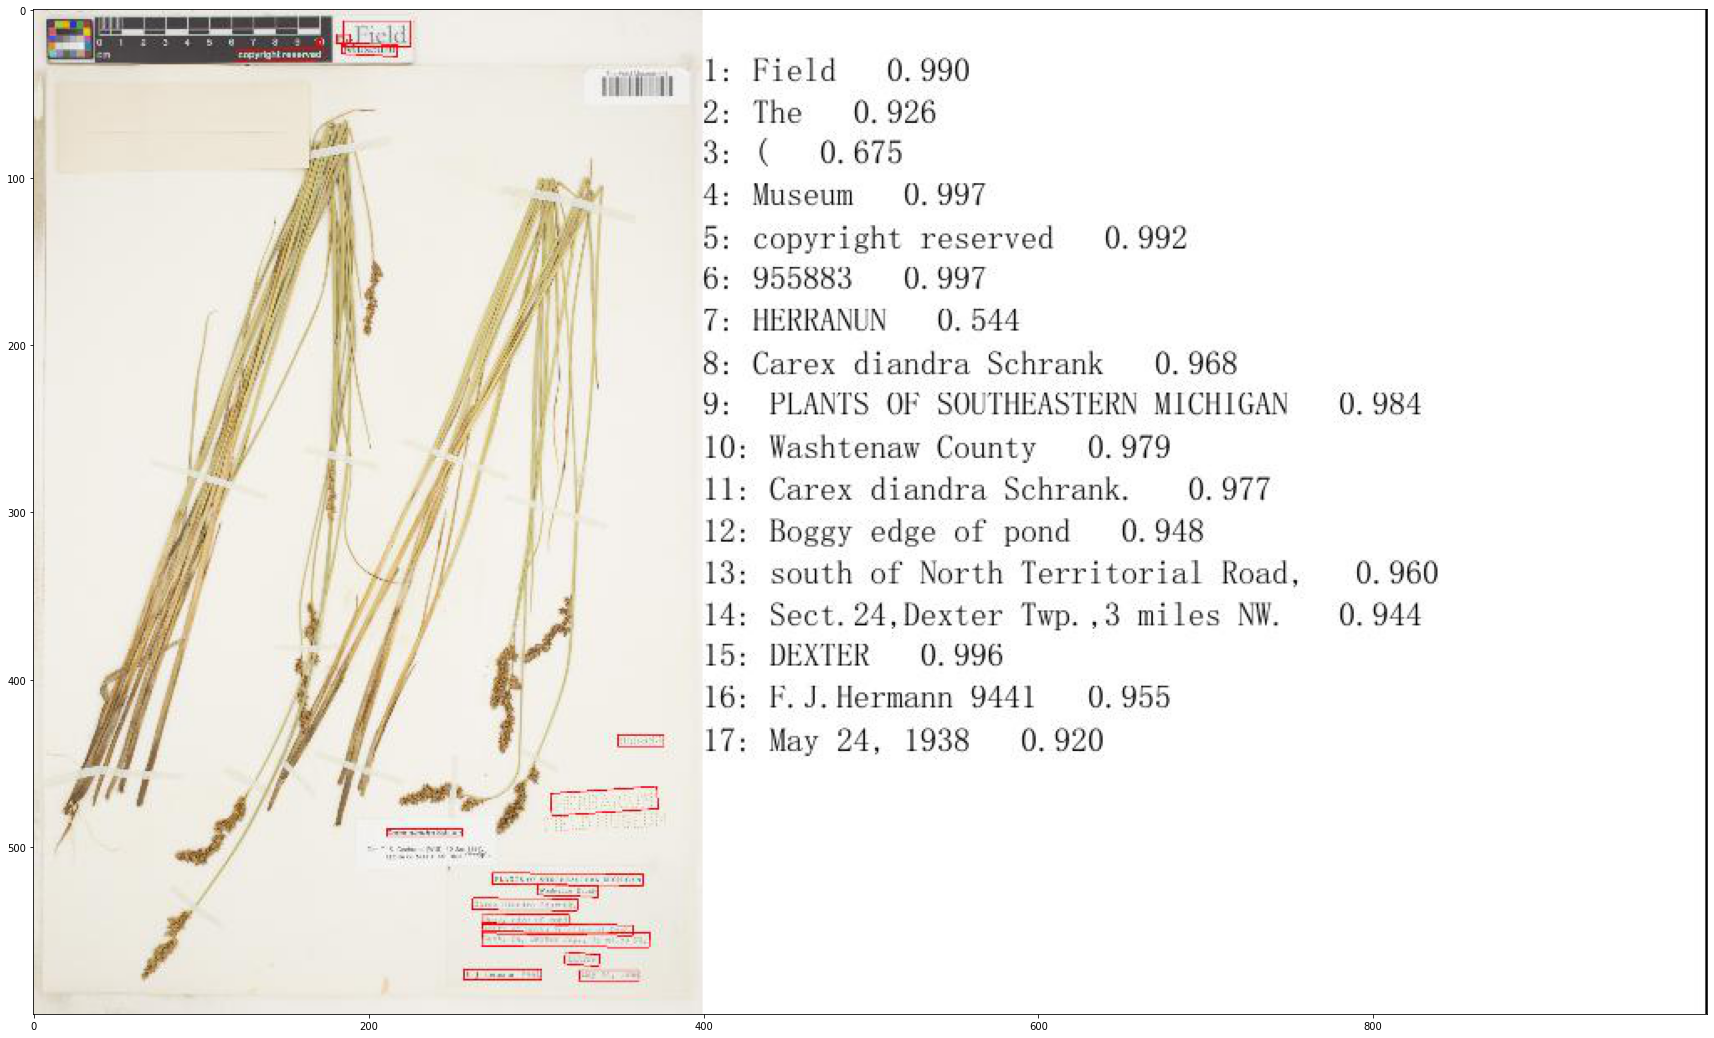

In [41]:
## 显示轻量级模型识别结果
img_path= "./output/result.jpg"
img_result = Image.open(img_path)
plt.figure("results_img", figsize=(30,30))
plt.imshow(img_result)
plt.show()

In [42]:
result

[[[[696.0, 26.0], [844.0, 26.0], [844.0, 84.0], [696.0, 84.0]],
  ('Field', 0.9904948472976685)],
 [[[680.0, 56.0], [710.0, 56.0], [710.0, 77.0], [680.0, 77.0]],
  ('The', 0.9256827235221863)],
 [[[635.0, 68.0], [647.0, 68.0], [647.0, 80.0], [635.0, 80.0]],
  ('(', 0.6750483512878418)],
 [[[692.0, 75.0], [816.0, 80.0], [815.0, 106.0], [691.0, 100.0]],
  ('Museum', 0.9972758293151855)],
 [[[457.0, 92.0], [651.0, 86.0], [652.0, 112.0], [457.0, 117.0]],
  ('copyright reserved', 0.9922589063644409)],
 [[[1310.0, 1624.0], [1413.0, 1624.0], [1413.0, 1650.0], [1310.0, 1650.0]],
  ('955883', 0.9969935417175293)],
 [[[1159.0, 1756.0], [1397.0, 1740.0], [1400.0, 1790.0], [1162.0, 1806.0]],
  ('HERRANUN', 0.5439633131027222)],
 [[[792.0, 1835.0], [961.0, 1835.0], [961.0, 1852.0], [792.0, 1852.0]],
  ('Carex diandra Schrank', 0.9683398008346558)],
 [[[1029.0, 1934.0], [1366.0, 1936.0], [1366.0, 1962.0], [1029.0, 1959.0]],
  (' PLANTS OF SOUTHEASTERN MICHIGAN', 0.984470009803772)],
 [[[1130.0, 1959

In [44]:
img.shape

(2250, 1500, 3)

[2022/11/07 17:02:33] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/usr4/dl523/dong760/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/usr4/dl523/dong760/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thr

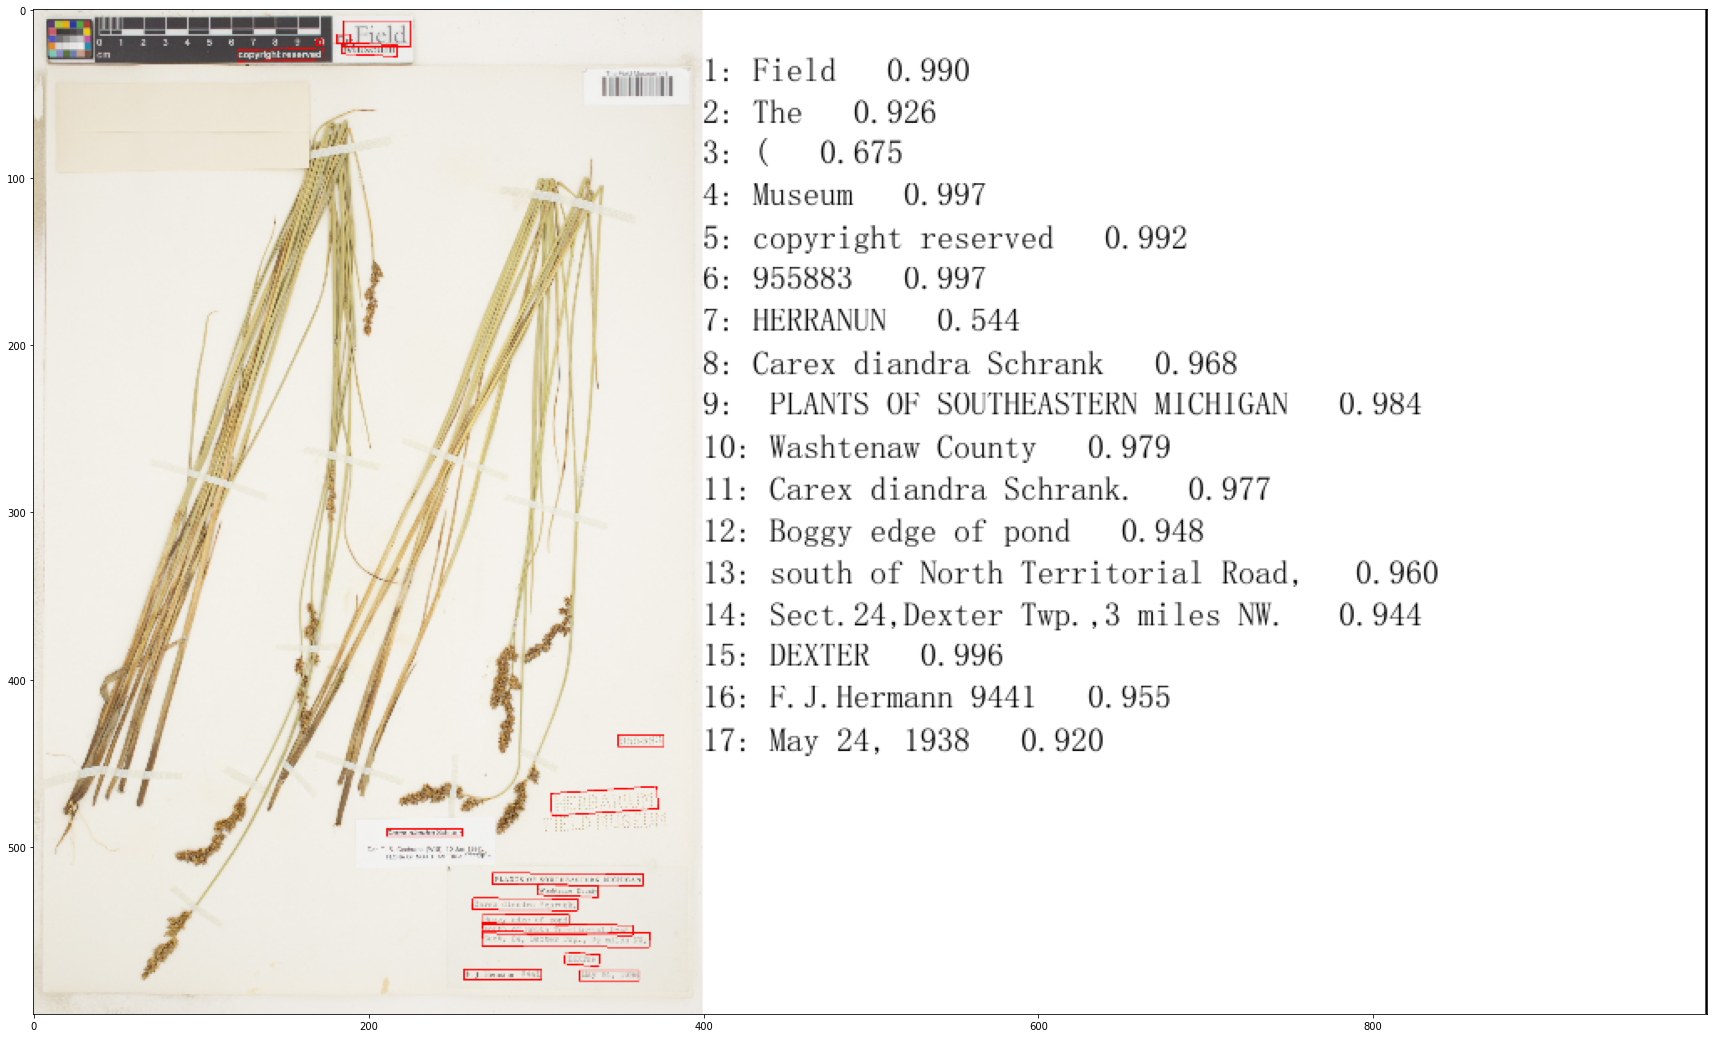

In [61]:
def display_OCR_result_with_imgID(imgID):
    """
    Args:
        @imgID: str, a str format id for the image to display
    Example:
        >>> timestr = time.strftime("%Y%m%d%H%M%S_")
        >>> save_path = os.path.join(PROJECT_DIR+"output/")+timestr+".jpg"
        >>> display_OCR_result_with_imgID('1228540653', save_path)
    """
    # Get img as nparr
    img = img_dict[imgID]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Use PaddleOCR to make prediction
    ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu = False, use_mp=True)
    result = ocr.ocr(img, cls=True)
    result = np.squeeze(np.array(result), axis=0) # Remove redundant dim and transform to nparr, e.g., [1, 19, 4, 2] --> [19, 4, 2]

    # draw result
    from PIL import Image
    print(result)
    print(result.shape)
    # image = Image.open(img_path).convert('RGB')
    boxes = [line[0] for line in result]
    txts = [line[1][0] for line in result]
    scores = [line[1][1] for line in result]
    im_show = draw_ocr(img,   # image(Image|array): RGB image
                       boxes, # boxes(list): boxes with shape(N, 4, 2)
                       txts,  # txts(list): the texts
                       scores, # confidence
                       drop_score=0.1, # drop_score(float): only scores greater than drop_threshold will be visualized
                       font_path='./doc/fonts/simfang.ttf') # font_path: the path of font which is used to draw text
    im_show = Image.fromarray(im_show)
    # im_show.save('./output/result.jpg')  # Save the result
    plt.figure("results_img", figsize=(30,30))
    plt.imshow(im_show)
    plt.show()
#     result = ocr.ocr(img, rec=False) # support ndarray, img_path and list or ndarray
#     result = np.squeeze(np.array(result))
#     print(result.shape)
#     draw_bbox_on_img(img, result)
display_OCR_result_with_imgID('1228540653')

## Comparing the result to CRAFT

In [16]:
boxes = {}
def addBox(fname):
	if ".jpg" in fname and "mask" not in fname:
		# imgs.append(cv2.imread(os.path.join(craft_res_dir, fname)))
		tmp_txt = open(os.path.join(craft_res_dir, fname[:len(fname)-3]+"txt"),"r").read().split("\n")[:-1]
		tmp_txt = [line.split(",") for line in tmp_txt]
		tmp_bxs = [[[int(line[i]),int(line[i+1])] for i,val in enumerate(line) if int(i)%2==0] for line in tmp_txt ]
		boxes[fname[4:len(fname)-4]] = tmp_bxs
		return boxes
def fillBoxes():
	print("\nFilling boxes dictionary...")
	print("Starting multiprocessing...")
	list_imgs = sorted(os.listdir(craft_res_dir))
	pool = mp.Pool(NUM_CORES)
	for item in tqdm(pool.imap(addBox, list_imgs), total=len(sorted(os.listdir(craft_res_dir)))):
		if item: boxes.update(item)
	pool.close()
	pool.join()
	print("\nBoxes dictionary filled.\n")
# Get all the bounding boxes that segmented by CRAFT
fillBoxes()
print(f"imgIDs that extracted by CRAFT: {boxes.keys()}")


Filling boxes dictionary...
Starting multiprocessing...


100%|██████████| 90/90 [00:00<00:00, 13336.89it/s]


Boxes dictionary filled.

imgIDs that extracted by CRAFT: dict_keys(['1228540653', '1456077691', '1675922214', '1699810828', '1701985163', '1702403767', '1805438386', '1928727829', '1930079276', '1991447360', '1998924583', '1998999444', '1999141230', '1999191965', '1999346883', '2236069168', '2265361450', '2513962787', '2514610251', '2515453969', '2516377361', '2516548361', '2517498948', '2900391670', '3016518613', '3416707636', '436989369', '437989544', '438312026', '574701445'])


(56, 4, 2)


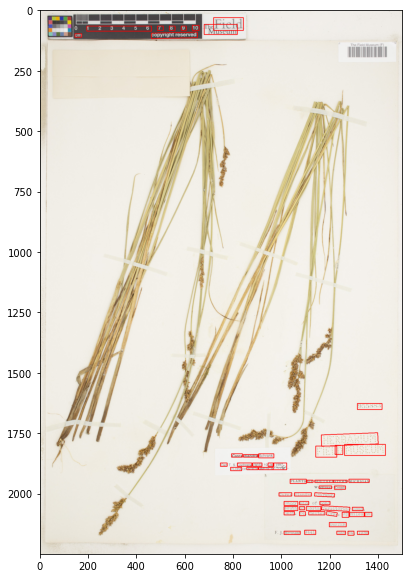

In [17]:
box = np.array(boxes["1228540653"])
print(box.shape)
draw_bbox_on_img(img, box)

## Let's write a function to perform inference on all images:

In [66]:
# 2. Declare the PaddleOCR class. Read this refer to other parameter, https://pypi.org/project/paddleocr/
ocr = PaddleOCR(use_angle_cls=True, 
                det_algorithm="DB",          # ['DB', "EAST"]
                rec_algorithm="SVTR_LCNet",  # ['CRNN', 'SVTR_LCNet'], ....Rosetta、CRNN、STAR-Net、RARE
#                 det_model_dir=".pretrain_models/",
#                 rec_model_dir="",
                use_gpu=False, 
                lang='en') # need to run only once to download and load model into memory

# Making prediction
imgID_list = list(img_dict.keys())
predition_dict = {} # key: imgID, val: (predicted_bboes, predicted_res)
def inference_all_imgs(img_list):
    """
    Args:
        @img_list: a list of <str: imgId, nparr: img_arr>
    """
    predicted_result = []
    for imgId, img in img_list:
        # 3. Perform prediction
        predition_dict[imgId] = ocr.ocr(img) 
        # return a list of [boxes, (pred_text, conf)], e.g., [[[696.0, 26.0], [844.0, 26.0], [844.0, 84.0], [696.0, 84.0]], ('Field', 0.9904948472976685)]
inference_all_imgs(img_list)

[2022/11/07 17:30:18] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/usr4/dl523/dong760/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/usr4/dl523/dong760/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thr

In [67]:
print(len(predition_dict))
print(predition_dict.keys())
predition_dict['1228540653']

30
dict_keys(['1228540653', '1456077691', '1675922214', '1699810828', '1701985163', '1702403767', '1805438386', '1928727829', '1930079276', '1991447360', '1998924583', '1998999444', '1999141230', '1999191965', '1999346883', '2236069168', '2265361450', '2513962787', '2514610251', '2515453969', '2516377361', '2516548361', '2517498948', '2900391670', '3016518613', '3416707636', '436989369', '437989544', '438312026', '574701445'])


[[[[[693.0, 29.0], [842.0, 23.0], [844.0, 81.0], [695.0, 87.0]],
   ('Field', 0.9891648292541504)],
  [[[588.0, 68.0], [602.0, 68.0], [602.0, 80.0], [588.0, 80.0]],
   ('9', 0.617920458316803)],
  [[[635.0, 68.0], [647.0, 68.0], [647.0, 80.0], [635.0, 80.0]],
   ('(', 0.6803601384162903)],
  [[[680.0, 59.0], [712.0, 59.0], [712.0, 77.0], [680.0, 77.0]],
   ('The', 0.9976139068603516)],
  [[[692.0, 75.0], [816.0, 80.0], [815.0, 106.0], [691.0, 100.0]],
   ('Museum', 0.9971880912780762)],
  [[[145.0, 96.0], [171.0, 96.0], [171.0, 112.0], [145.0, 112.0]],
   ('cm', 0.9682004451751709)],
  [[[455.0, 87.0], [654.0, 84.0], [654.0, 117.0], [455.0, 120.0]],
   ('copyright reserved', 0.988673746585846)],
  [[[1310.0, 1624.0], [1413.0, 1624.0], [1413.0, 1650.0], [1310.0, 1650.0]],
   ('955883', 0.9968652129173279)],
  [[[1162.0, 1754.0], [1398.0, 1746.0], [1400.0, 1795.0], [1164.0, 1803.0]],
   ('HENBARON', 0.584071159362793)],
  [[[1134.0, 1801.0], [1423.0, 1788.0], [1426.0, 1837.0], [1136.0, 1

## Loading ground truth value for each imgId, as well as the corpus for taxon, geography, and collector

In [68]:
# String matching installs
# !pip install numpy==1.22.4 # need version '1.22.4' to work the string grouper
# !pip install string-grouper==0.1.1
# print(np.__version__)
import pandas as pd
from string_grouper import match_strings, match_most_similar

First, let's load all the ground trush result in to memory.  --> We will create a dict to store all the gt result, and use set to store all the corpus.
- gt_dict = {}  # <key: imgId, val: (taxon, geography, collector)
- xxx_corpus_set = set()

In [69]:
# Building corpus set
# Use set for O(1) look up, and remove duplicated item
taxon_corpus_set     = set(pd.read_csv(DATASET_PATH +'/taxon_corpus.txt', delimiter = "\t", names=["Taxon"]).squeeze())
geography_corpus_set = set(pd.read_csv(DATASET_PATH +'/geography_corpus.txt', delimiter = "\t", names=["Geography"]).squeeze())
collector_corpus_set = set(pd.read_csv(DATASET_PATH +'/collector_corpus.txt', delimiter = "\t", names=["Collector"]).squeeze())

In [70]:
pd.Series(list(taxon_corpus_set))

0              Kanahia laniflora
1                Liatris virgata
2          Muhlenbergia racemosa
3       Ranunculus pensylvanicus
4          Eleocharis acicularis
5            Picris hieracioides
6             Tillandsia bulbosa
7           Thuidium delicatulum
8                 Sagina nivalis
9                Carex saxatilis
10         Erythrina standleyana
11                 Ixora euosmia
12    Rhododendron calendulaceum
13               Ardisia crenata
14             Didymodoxa caffra
15            Lophozia guttulata
16            Rinorea guianensis
17            Ochna leucophloeos
18            Dianthus deltoides
19     Eriodictyon angustifolium
20                 Carex diandra
21         Taraxacum ostenfeldii
22                 Poa compressa
23         Brachypodium pringlei
24             Chylismia walkeri
25        Chenopodiastrum murale
26            Koeleria macrantha
27             Salvia rosmarinus
28    Malacothamnus fasciculatus
29             Swertia marginata
dtype: obj

In [90]:
# Building gt_dict
gt_dict = {}
str_lst = ['taxon', 'geography', 'collector']
Taxon_truth = { line.split(":")[0] : line.split(": ")[1].strip() for line in open(DATASET_PATH + '/taxon_gt.txt') }
Geography_truth = { line.split(":")[0] : line.split(": ")[1].strip() for line in open(DATASET_PATH + '/geography_gt.txt') }
Collector_truth = { line.split(":")[0] : line.split(": ")[1].strip() for line in open(DATASET_PATH + '/collector_gt.txt') }
# comparison_file = {"Taxon":Taxon_truth,"Geography":Geography_truth,"Collector":Collector_truth}
for imgId in predition_dict.keys():
    gt_dict[imgId] = {str_lst[0]: Taxon_truth[imgId], str_lst[1]: Geography_truth[imgId], str_lst[2]: Collector_truth[imgId]}

In [91]:
gt_dict

{'1228540653': {'taxon': 'Carex diandra',
  'geography': 'United States of America',
  'collector': 'F. J. Hermann'},
 '1456077691': {'taxon': 'Liatris virgata',
  'geography': 'United States of America',
  'collector': 'J. Donnell Smith'},
 '1675922214': {'taxon': 'Eleocharis acicularis',
  'geography': 'Greenland',
  'collector': 'M. P. Porsild & R. T. Porsild'},
 '1699810828': {'taxon': 'Didymodoxa caffra',
  'geography': 'Tanzania, United Republic of',
  'collector': 'Volkens, G.'},
 '1701985163': {'taxon': 'Dianthus deltoides',
  'geography': 'Norway',
  'collector': 'Askell Røskeland'},
 '1702403767': {'taxon': 'Picris hieracioides',
  'geography': 'Norway',
  'collector': 'Anton Landmark'},
 '1805438386': {'taxon': 'Lophozia guttulata',
  'geography': 'United States of America',
  'collector': 'George E. Nichols'},
 '1928727829': {'taxon': 'Erythrina standleyana',
  'geography': 'Cuba',
  'collector': 'E. L. Ekman'},
 '1930079276': {'taxon': 'Rhododendron calendulaceum',
  'geog

## Let's first save those temporary gt_result and predicted_result into a pickle file

In [92]:
import pickle
PP_OCR_output_dir = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/PP_OCR_data/"

# Save groud trush result
gt_name = 'gt_result.pkl'
dbfile = open(PP_OCR_output_dir+gt_name, 'ab')
pickle.dump(gt_dict, dbfile)
dbfile.close()
df = pd.DataFrame.from_dict(gt_dict, orient='index').rename(columns={0: 'taxon',1: 'geography',2: 'collector'})
df.to_pickle(PP_OCR_output_dir+gt_name)

# Save predicted result
predicted_name = 'predicted_result.pkl'
df = pd.DataFrame.from_dict(predition_dict, orient='index')
df.to_pickle(PP_OCR_output_dir+predicted_name)

# df = pd.DataFrame(predition_dict.keys(),predition_dict.values(), labels)), columns = ['imgId','predicted_result', 'Labels'])

In [93]:
#### For loading pickle files that you saved
def load_pickle(filepath):
    filepkl = open(filepath, "rb")
    unpickled = pickle.load(filepkl)  # Unpickle the objects
    return unpickled

gt_series = load_pickle(PP_OCR_output_dir + gt_name)
predition_series = load_pickle(PP_OCR_output_dir + predicted_name)

gt_dict = load_pickle(PP_OCR_output_dir + gt_name).to_dict('index')
predition_dict = load_pickle(PP_OCR_output_dir + predicted_name).to_dict('index')

In [94]:
display(gt_series.head())
gt_dict['1805438386']

,taxon,geography,collector
1228540653,Carex diandra,United States of America,F. J. Hermann
1456077691,Liatris virgata,United States of America,J. Donnell Smith
1675922214,Eleocharis acicularis,Greenland,M. P. Porsild & R. T. Porsild
1699810828,Didymodoxa caffra,"Tanzania, United Republic of","Volkens, G."
1701985163,Dianthus deltoides,Norway,Askell Røskeland


{'taxon': 'Lophozia guttulata',
 'geography': 'United States of America',
 'collector': 'George E. Nichols'}

In [95]:
predition_dict['1805438386']

{0: [[[[182.0, 89.0], [315.0, 89.0], [315.0, 158.0], [182.0, 158.0]],
   ('231', 0.9867734909057617)],
  [[[485.0, 120.0], [1174.0, 120.0], [1174.0, 148.0], [485.0, 148.0]],
   ('HERBARIUM OFYALEUNIVERSITY', 0.9399808645248413)],
  [[[270.0, 182.0], [1378.0, 184.0], [1378.0, 218.0], [270.0, 216.0]],
   ('BRYOPHYTES OF MICHIGAN,EMMET AND CHEBOYGAN COUNTIES',
    0.8528973460197449)],
  [[[220.0, 237.0], [581.0, 237.0], [581.0, 323.0], [220.0, 323.0]],
   ('Loalszia', 0.6824450492858887)],
  [[[982.0, 240.0], [1221.0, 248.0], [1219.0, 309.0], [980.0, 302.0]],
   ('eea', 0.8934791684150696)],
  [[[877.0, 457.0], [1253.0, 443.0], [1254.0, 481.0], [879.0, 494.0]],
   ('Vicinity of Burt', 0.9411656260490417)],
  [[[947.0, 496.0], [1279.0, 484.0], [1281.0, 518.0], [948.0, 530.0]],
   ('ToulasTae', 0.8086454272270203)],
  [[[275.0, 574.0], [884.0, 569.0], [885.0, 596.0], [275.0, 601.0]],
   ('COLLECTED BY GEORGE E.NICHOLS', 0.9278839826583862)],
  [[[1049.0, 569.0], [1367.0, 575.0], [1366.0, 6

## Now let's use string matching to perform evaluation

In [81]:
gt_series.loc['1805438386']['taxon']

'Lophozia guttulata'

In [81]:
def prRed(skk): print("\033[91m{}\033[00m" .format(skk))
    
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [82]:
predition_dict.keys()

dict_keys(['1228540653', '1456077691', '1675922214', '1699810828', '1701985163', '1702403767', '1805438386', '1928727829', '1930079276', '1991447360', '1998924583', '1998999444', '1999141230', '1999191965', '1999346883', '2236069168', '2265361450', '2513962787', '2514610251', '2515453969', '2516377361', '2516548361', '2517498948', '2900391670', '3016518613', '3416707636', '436989369', '437989544', '438312026', '574701445'])

In [86]:
total_pred = {'taxon': 0, 'geography': 0, 'collector': 0}
correct_pred = {'taxon': 0, 'geography': 0, 'collector': 0}
pred_threshold = 0.8
min_similarity = 0.1
corpus_set = [taxon_corpus_set, geography_corpus_set, collector_corpus_set]
str_lst = ['taxon', 'geography', 'collector']

    
print(f"Corrected Prediction Format: {color.GREEN} Pred_category(corr_count/total_count): gt_result || predicted_result || imgID {color.END}")
for imgId, pred_results in predition_dict.items():
    # image = Image.open(img_path).convert('RGB')
    pred_results = pred_results[0]
    boxes = [line[0] for line in pred_results] # a list of list, e.g., [[696.0, 26.0], [844.0, 26.0], [844.0, 84.0], [696.0, 84.0]]
    txts = [line[1][0] for line in pred_results] # a list of str, e.g., 'Field'
    scores = [line[1][1] for line in pred_results] # a list of float, e.g., 0.9960
    
    # print(scores)
    for i in range(3):
        match_df = match_strings(pd.Series(list(corpus_set[i])), pd.Series(txts), min_similarity = min_similarity, max_n_matches = 1)
        
        # match_df = matches_above_x(match_df, threshold)
        # Get the one with highest similarity as predicted result
        if not match_df.empty:
            # display(match_df)
            # print(match_df.loc[match_df['similarity'].idxmax()])
            predicted_txt    = match_df.loc[match_df['similarity'].idxmax()]['left_side']
            if predicted_txt in corpus_set[i]:
                total_pred[str_lst[i]] += 1
                # gt = gt_series.loc[imgId][str_lst[i]]
                gt = gt_dict[imgId][str_lst[i]]
                if predicted_txt == gt:
                    correct_pred[str_lst[i]] += 1
                    print(f"{color.GREEN}{str_lst[i]+'('+str(correct_pred[str_lst[i]])+'/'+str(total_pred[str_lst[i]])+'):': <15} {gt} || {predicted_txt} || {imgId}  {color.END}")
                else:
                    print(f"{str_lst[i]: <15}{gt} || {predicted_txt} || {imgId} ")
        else:
            print(f"{color.RED}Ground Truth Not Found for:{imgId}{color.END}")
    
print('\n\n********************************Report Statistics')
acc_lst = [round(correct_pred[i]/total_pred[i], 4) for i in str_lst]
print(acc_lst)
print(f"Total Images had been processed for evaluation: {len(predition_dict.keys())}")
print(f"Total Prediction: taxon: {total_pred['taxon']}, geography: {total_pred['geography']}, collector: {total_pred['collector']}")
print(f"Correct Prediction: taxon: {correct_pred['taxon']}, geography: {correct_pred['geography']}, collector: {correct_pred['collector']}")
print(f"ACC: taxon: {acc_lst[0]}, geography: {acc_lst[1]}, collector: {acc_lst[2]}")
print(f"Average Acc: {sum(correct_pred.values())/sum(total_pred.values())}")

    

Corrected Prediction Format:  Pred_category(corr_count/total_count): gt_result || predicted_result || imgID 
{'taxon': 'Carex diandra', 'geography': 'United States of America', 'collector': 'F. J. Hermann'}
taxon(1/1):     Carex diandra || Carex diandra || 1228540653  
{'taxon': 'Carex diandra', 'geography': 'United States of America', 'collector': 'F. J. Hermann'}
geography      United States of America || Netherlands || 1228540653 
{'taxon': 'Carex diandra', 'geography': 'United States of America', 'collector': 'F. J. Hermann'}
collector(1/1): F. J. Hermann || F. J. Hermann || 1228540653  
{'taxon': 'Liatris virgata', 'geography': 'United States of America', 'collector': 'J. Donnell Smith'}
taxon(2/2):     Liatris virgata || Liatris virgata || 1456077691  
{'taxon': 'Liatris virgata', 'geography': 'United States of America', 'collector': 'J. Donnell Smith'}
geography      United States of America || Canada || 1456077691 
{'taxon': 'Liatris virgata', 'geography': 'United States of Ame

### Let's try out some example in using string_grouper
Reference:
- https://pypi.org/project/string-grouper/0.1.1/
- Super Fast String Matching in Python, https://bergvca.github.io/2017/10/14/super-fast-string-matching.html
- Code example, String Grouper, https://github.com/Bergvca/string_grouper

In [76]:
test_item = np.array(list(predition_dict['1228540653'].values())).squeeze(axis=0)
test_item.shape

(17, 2)

In [77]:
results_series = pd.Series(item[0] for item in test_item[:, 1])
results_series

0                                Field
1                                  The
2                                    (
3                               Museum
4                   copyright reserved
5                               955883
6                             HERRANUN
7                Carex diandra Schrank
8      PLANTS OF SOUTHEASTERN MICHIGAN
9                     Washtenaw County
10              Carex diandra Schrank.
11                  Boggy edge of pond
12    south of North Territorial Road,
13     Sect.24,Dexter Twp.,3 miles NW.
14                              DEXTER
15                    F.J.Hermann 9441
16                        May 24, 1938
dtype: object

In [38]:
# String matching
minimum_similarity = .1
start = time.time()
matches = match_strings(taxon, results_series, min_similarity = minimum_similarity, max_n_matches = 4)
end = time.time()
print('time',end-start)
matches
# matches = match_strings(taxon, pd_res, ngram_size=45, min_similarity = minimum_similarity)

time 0.04556393623352051


,left_side,right_side,similarity
0,Euphrasia officinalis,Carex diandra Schrank.,0.124850
1,Euphrasia officinalis,Carex diandra Schrank,0.124850
2,Carex typhina,DEXTER,0.181576
3,Carex typhina,Carex diandra Schrank.,0.126579
4,Carex typhina,Carex diandra Schrank,0.126579
...,...,...,...
223,Arytera litoralis,"south of North Territorial Road,",0.125732
224,Abutilon theophrasti,The,0.197320
225,Abutilon theophrasti,Carex diandra Schrank.,0.127687
226,Abutilon theophrasti,Carex diandra Schrank,0.127687


In [43]:
results_series.shape

(17,)

In [42]:
for guess in results_series:
    print(guess)

Field
The
(
Museum
copyright reserved
955883
HERRANUN
Carex diandra Schrank
 PLANTS OF SOUTHEASTERN MICHIGAN
Washtenaw County
Carex diandra Schrank.
Boggy edge of pond
south of North Territorial Road,
Sect.24,Dexter Twp.,3 miles NW.
DEXTER
F.J.Hermann 9441
May 24, 1938


In [40]:
taxon

0                   Euphrasia officinalis
1       Bryoerythrophyllum recurvirostrum
2                     Carduus tenuiflorus
3                     Agoseris parviflora
4                       Spiraea canescens
                      ...                
1003                   Cleidion javanicum
1004                        Lotus alpinus
1005              Diplazium polypodioides
1006                         Populus alba
1007                   Cymbalaria muralis
Name: Taxon, Length: 1008, dtype: object

In [28]:

imgIds_list

['1228540653',
 '1456077691',
 '1675922214',
 '1699810828',
 '1701985163',
 '1702403767',
 '1805438386',
 '1928727829',
 '1930079276',
 '1991447360',
 '1998924583',
 '1998999444',
 '1999141230',
 '1999191965',
 '1999346883',
 '2236069168',
 '2265361450',
 '2513962787',
 '2514610251',
 '2515453969',
 '2516377361',
 '2516548361',
 '2517498948',
 '2900391670',
 '3016518613',
 '3416707636',
 '436989369',
 '437989544',
 '438312026',
 '574701445']